In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
# step 1. Interest points detection and feature description
## Read images
img1 = cv2.imread('data/hill1.jpg')
img2 = cv2.imread('data/hill2.jpg') # 2 images we want to stitch
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB) # convert channels BGR to RGB

## Find keypoints and compute desctriptors in 2 images
sift_detector = cv2.xfeatures2d.SIFT_create()
(kp1, desc1) = sift_detector.detectAndCompute(img1,None) # kp is cv2.KeyPoint object
(kp2, desc2) = sift_detector.detectAndCompute(img2,None) # desc is numpy ndarray

In [ ]:
# step 2. Feature matching
## Use L2-norm Distance here
def L2_norm(desc1, desc2):
    dist = np.square(desc1 - desc2)
    return np.sum(dist)**0.5
good_matchs = []
for i in range(len(kp1)):
    dist_no1 = 100000000
    dist_no2 = 100000000
    index = -1
    index2 = -1
    for j in range(len(kp2)):
        dist = L2_norm(desc1[i],desc2[j])
        if dist < dist_no1:
            index2 = index
            index = j
            dist_no2 = dist_no1
            dist_no1 = dist
        elif dist < dist_no2:
            dist_no2 = dist
            index2 = j
    if (dist_no1/dist_no2) < 0.5:
        good_matchs.append([i,index])

In [4]:
## Visualize the matching result
### combine 2 images into 1
(h1, w1) = img1.shape[:2]
(h2, w2) = img2.shape[:2]
matching_result = np.zeros((max(h1, h2), w1 + w2, 3), dtype="uint8")
matching_result[0:h1, 0:w1] = img1
matching_result[0:h1, w1:] = img2
### draw the matching lines
for (i, j) in good_matchs:
    c = np.random.randint(0, high=255, size=(3,))
    color = tuple([int(x) for x in c])
    pt1 = (int(kp1[i].pt[0]), int(kp1[i].pt[1]))
    pt2 = (int(kp2[j].pt[0] + w1), int(kp2[j].pt[1]))
    cv2.line(matching_result, pt1, pt2, color, 1)

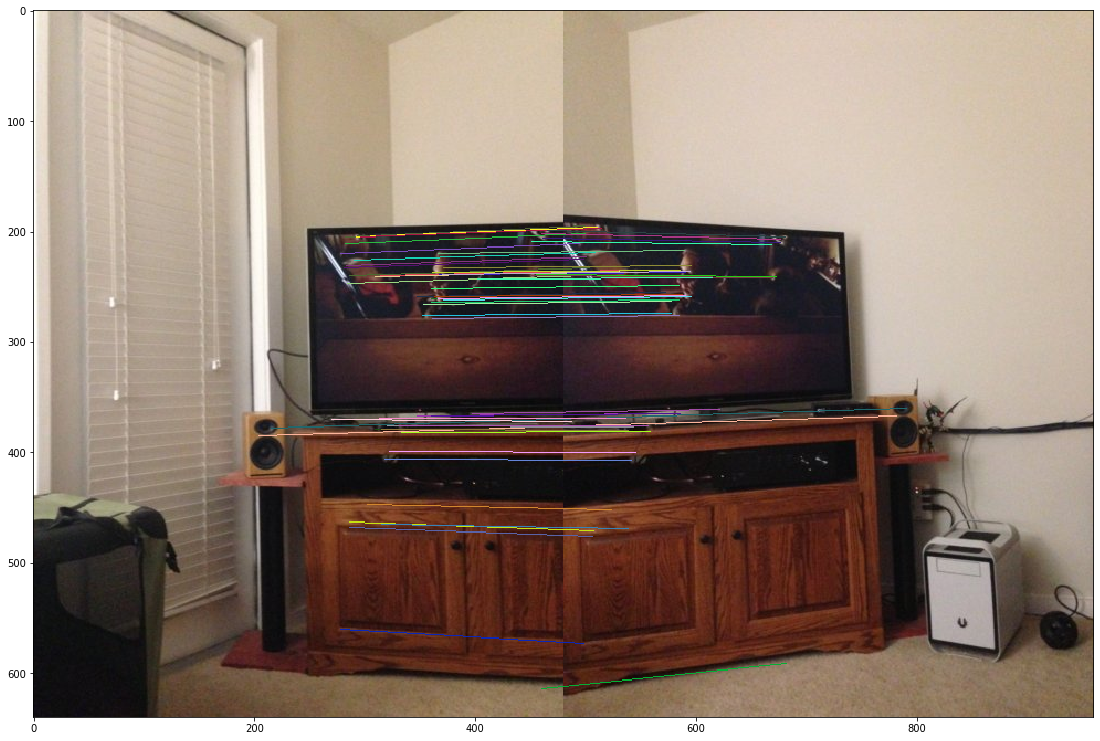

In [5]:
plt.figure(figsize=(26,13))
plt.imshow(matching_result)
plt.show()

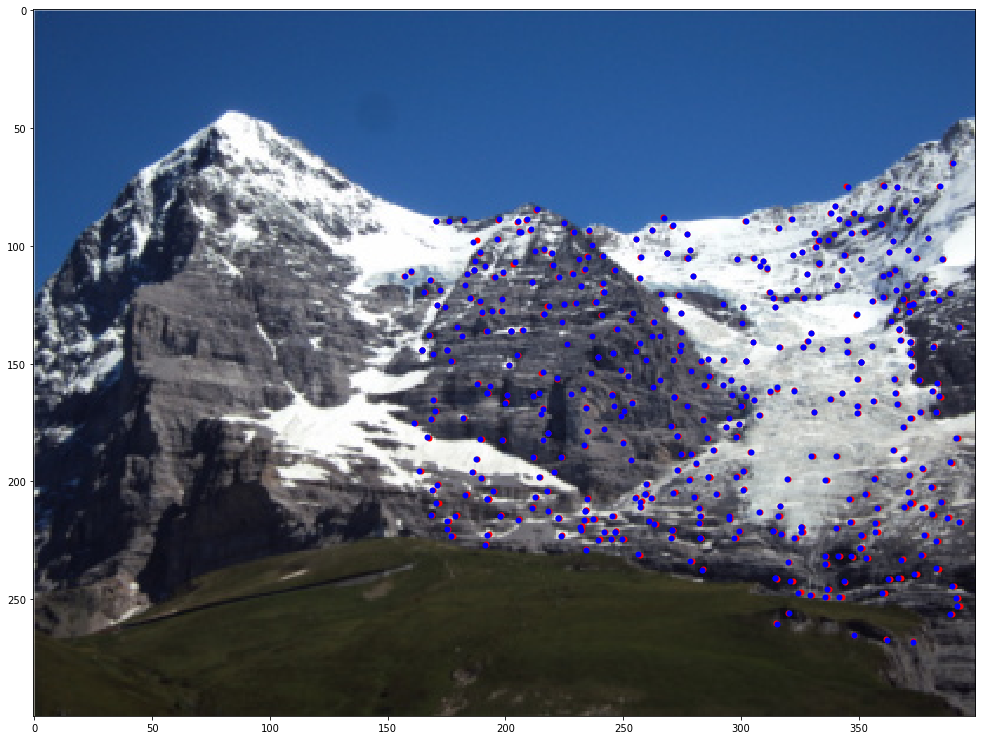

In [44]:
#config
RANSAC_iter = 500
RANSAC_sample_num = 4
threshold_distance = 5
threshold_inliners = 1

image1_kp = np.float32([kp1[i].pt for (i, _) in good_matchs])   
image2_kp = np.float32([kp2[i].pt for (_, i) in good_matchs]) 
image1_kp = np.insert(image1_kp, 2, 1, axis=1)
image2_kp = np.insert(image2_kp, 2, 1, axis=1)

#find best Homography matrix
for i in range(RANSAC_iter):
    ##get temp H via matches selected randomly
    rand_set = random.sample(good_matchs, RANSAC_sample_num)
    img1_kps = np.float32([kp1[i].pt for (i, _) in rand_set])
    img2_kps = np.float32([kp2[i].pt for (_, i) in rand_set])
    _H, _ = cv2.findHomography(img2_kps, img1_kps)
    ##calculate deviation of corresponding keypoints
    _projected_pts = np.dot(_H, image2_kp.T)
    error = np.sqrt(np.sum(np.square(image1_kp.T - (_projected_pts/_projected_pts[-1])), axis=0))
    
    ##count inliners
    inliners = np.count_nonzero(error < threshold_distance)
    
    ##Update 
    if inliners > threshold_inliners:
        ###preserve best Homography matrix
        H = _H
        projected_pts = (_projected_pts/_projected_pts[-1]).T
        threshold_inliners = inliners

#testing if H is good or not
img1_x, img1_y = image1_kp[:,0], image1_kp[:,1]
img2_x, img2_y = projected_pts[:,0], projected_pts[:,1]
plt.figure(figsize=(26,13)), plt.imshow(img1)
plt.scatter(img1_x,img1_y,linewidths=0.001,color = 'red')
plt.scatter(img2_x,img2_y,linewidths=0.001,color = 'blue')
plt.show()
